In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
import sklearn

from bayes_opt import BayesianOptimization

import time
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
df = pd.read_parquet('./data/dataframe.parquet')

In [3]:
df.columns

Index(['full_name', 'rating', 'jersey', 'team', 'position', 'b_day', 'height',
       'weight', 'salary', 'country', 'draft_year', 'draft_round',
       'draft_peak', 'college', 'year_born'],
      dtype='object')

In [4]:
df = df.drop(['full_name', 'jersey', 'team', 'position', 'b_day', 'country', 'college', 'year_born'], axis=1)

X = df.drop('salary', axis=1)
y = df['salary']

In [5]:
def lasso_eval(alpha, max_iter):
    lasso = Lasso(alpha = alpha, max_iter = max_iter)
    result = cross_val_score(lasso, 
                             X, 
                             y, 
                             scoring='neg_mean_squared_error', 
                             cv=KFold(5, True, 39), 
                             n_jobs=-1)
    return np.mean(result)

def ridge_eval(alpha, max_iter):
    ridge = Ridge(alpha = alpha, max_iter = max_iter)
    result = cross_val_score(ridge, 
                             X, 
                             y, 
                             scoring='neg_mean_squared_error', 
                             cv=KFold(5, True, 39), 
                             n_jobs=-1)
    return np.mean(result)

def elasticnet_eval(alpha, max_iter, l1):
    elasticnet = ElasticNet(alpha = alpha, max_iter = max_iter, l1_ratio=l1)
    result = cross_val_score(elasticnet, 
                             X, 
                             y, 
                             scoring='neg_mean_squared_error', 
                             cv=KFold(5, True, 39), 
                             n_jobs=-1)
    return np.mean(result)

In [6]:
lassoBO = BayesianOptimization(lasso_eval, 
                               {
                                    "alpha": (0.1, 2),
                                    "max_iter": (100, 1500)
                                },
                               verbose=1
                              )

lassoBO.maximize(n_iter=20, init_points=50)

|   iter    |  target   |   alpha   | max_iter  |
-------------------------------------------------
|  4        | -3e+13    |  0.466    |  179.6    |
|  6        | -3e+13    |  0.2719   |  776.1    |
|  61       | -3e+13    |  0.1135   |  179.0    |
|  62       | -3e+13    |  0.1083   |  178.1    |
|  70       | -3e+13    |  0.1019   |  1.015e+0 |


In [7]:
lassoBO.max

{'target': -30001659861071.133,
 'params': {'alpha': 0.10188186676814492, 'max_iter': 1014.8224099525694}}

In [8]:
ridgeBO = BayesianOptimization(ridge_eval, 
                               {
                                    "alpha": (0.1, 2),
                                    "max_iter": (100, 1500)
                                },
                              verbose=1
                              )

ridgeBO.maximize(n_iter=20, init_points=50)

|   iter    |  target   |   alpha   | max_iter  |
-------------------------------------------------
|  3        | -3e+13    |  1.805    |  771.1    |
|  20       | -3e+13    |  1.971    |  505.4    |
|  50       | -3e+13    |  1.983    |  1.217e+0 |


In [9]:
ridgeBO.max

{'target': -29998536986592.867,
 'params': {'alpha': 1.9831801082589824, 'max_iter': 1216.8737684523007}}

In [10]:
elasticBO = BayesianOptimization(elasticnet_eval, 
                                 {
                                    "alpha": (0.1, 2),
                                    "max_iter": (100, 1500),
                                    "l1": (0.0, 1.0)
                                },
                                verbose=1)

elasticBO.maximize(n_iter=20, init_points=50)

|   iter    |  target   |   alpha   |    l1     | max_iter  |
-------------------------------------------------------------
|  3        | -2.986e+1 |  1.969    |  0.4765   |  509.0    |
|  7        | -2.986e+1 |  1.992    |  0.5801   |  873.1    |
|  9        | -2.986e+1 |  1.015    |  0.2212   |  1.062e+0 |
|  30       | -2.986e+1 |  1.173    |  0.3488   |  1.472e+0 |


In [11]:
elasticBO.max

{'target': -29855722188168.22,
 'params': {'alpha': 1.1731348766464769,
  'l1': 0.34875352540418936,
  'max_iter': 1472.2697783167118}}

In [12]:
elasticBO.max['params']['alpha']

1.1731348766464769

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=39)

In [40]:
def predict(x_train, x_test, y_train, y_test, model_list):
    model_names = ['Linear Regression', 'Lasso', 'Ridge', 'ElasticNet']
    return_df = pd.DataFrame()
    return_df.insert(len(return_df.columns), 'Salário Real', y_test)
    
    for model, model_name in zip(model_list, model_names):
        t1 = time.time()
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        t2 = time.time()
        pred[pred < 0] = 0
        print(f'{model_name} Score: {model.score(x_test, y_test)}')
        print(f'{model_name} RMSE: {mean_squared_error(y_test, pred, squared=False)}')
        print(f'Tempo para executar o modelo (treino + teste): {format(t2-t1, "f")} segundos')
        return_df.insert(len(return_df.columns), f'{model_name}', pred)
    
    for column in return_df.columns:
        return_df[column] = return_df[column].transform(lambda x: format(x, 'f'))
    return return_df

In [49]:
def plot_histograms(df):
    for i, column in enumerate(df.columns):
        if i == 0:
            continue
        sns.distplot(x=df['Salário Real'], kde=False, bins=5)
        sns.distplot(x=df[column], kde=False, bins=5)
        plt.legend(['Salários Reais', f'Previsão {column}'])
        plt.show()

Linear Regression Score: 0.6475892233560498
Linear Regression RMSE: 5530923.458582754
Tempo para executar o modelo (treino + teste): 0.006995 segundos
Lasso Score: 0.6475892949382211
Lasso RMSE: 5530923.089666939
Tempo para executar o modelo (treino + teste): 0.007995 segundos
Ridge Score: 0.6480201502820248
Ridge RMSE: 5528973.654054534
Tempo para executar o modelo (treino + teste): 0.011995 segundos
ElasticNet Score: 0.6489865941625917
ElasticNet RMSE: 5530134.402054923
Tempo para executar o modelo (treino + teste): 0.010994 segundos


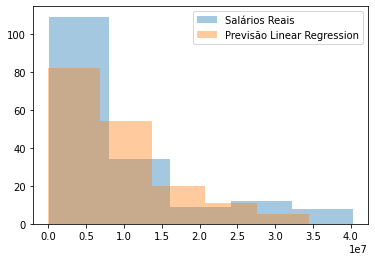

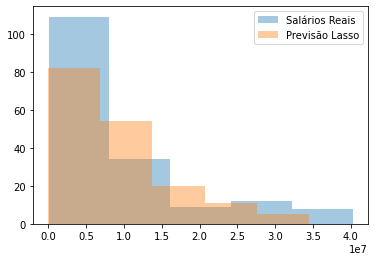

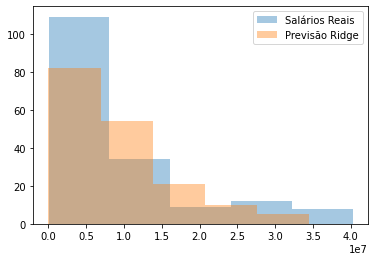

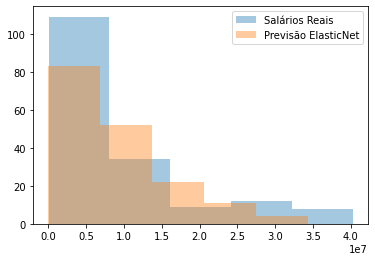

In [50]:
model_list = [LinearRegression(), 
              Lasso(), 
              Ridge(), 
              ElasticNet()]

t1 = time.time()
results = predict(x_train, x_test, y_train, y_test, model_list)
plot_histograms(results)

In [16]:
model_list = [LinearRegression(), 
              Lasso(alpha = lassoBO.max['params']['alpha'], 
                    max_iter = lassoBO.max['params']['max_iter']), 
              Ridge(alpha = ridgeBO.max['params']['alpha'], 
                    max_iter = ridgeBO.max['params']['max_iter']), 
              ElasticNet(alpha = elasticBO.max['params']['alpha'],
                        l1_ratio = elasticBO.max['params']['l1'],
                        max_iter = elasticBO.max['params']['max_iter'])]

results_bay = predict(x_train, x_test, y_train, y_test, model_list)

Linear Regression Score: 0.6420815660593562
Linear Regression RMSE: 5584348.657018192
Tempo para executar o modelo (treino + teste): 0.003998 segundos
Lasso Score: 0.6420815629563266
Lasso RMSE: 5584348.665644829
Tempo para executar o modelo (treino + teste): 0.005996 segundos
Ridge Score: 0.6423471511396466
Ridge RMSE: 5582280.369769998
Tempo para executar o modelo (treino + teste): 0.004996 segundos
ElasticNet Score: 0.6496666836223295
ElasticNet RMSE: 5533772.53781398
Tempo para executar o modelo (treino + teste): 0.003998 segundos


Feature Selection

In [17]:
selector = RFECV(LinearRegression(), step=1, min_features_to_select=3, n_jobs=-1, verbose=2)
selector = selector.fit(X, y)
selector.ranking_

Fitting estimator with 6 features.
Fitting estimator with 5 features.


array([1, 1, 2, 1, 1, 3])

In [18]:
X = df.drop(['salary', 'weight', 'draft_peak'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=39)

In [19]:
model_list = [LinearRegression(), 
              Lasso(), 
              Ridge(), 
              ElasticNet()]

results_fea = predict(x_train, x_test, y_train, y_test, model_list)

Linear Regression Score: 0.6475892233560498
Linear Regression RMSE: 5530923.458582754
Tempo para executar o modelo (treino + teste): 0.004001 segundos
Lasso Score: 0.6475892949382211
Lasso RMSE: 5530923.089666939
Tempo para executar o modelo (treino + teste): 0.003998 segundos
Ridge Score: 0.6480201502820248
Ridge RMSE: 5528973.654054534
Tempo para executar o modelo (treino + teste): 0.004000 segundos
ElasticNet Score: 0.6489865941625917
ElasticNet RMSE: 5530134.402054923
Tempo para executar o modelo (treino + teste): 0.005995 segundos


In [20]:
model_list = [LinearRegression(), 
              Lasso(alpha = lassoBO.max['params']['alpha'], 
                    max_iter = lassoBO.max['params']['max_iter']), 
              Ridge(alpha = ridgeBO.max['params']['alpha'], 
                    max_iter = ridgeBO.max['params']['max_iter']), 
              ElasticNet(alpha = elasticBO.max['params']['alpha'],
                        l1_ratio = elasticBO.max['params']['l1'],
                        max_iter = elasticBO.max['params']['max_iter'])]

results_fea_bay = predict(x_train, x_test, y_train, y_test, model_list)

Linear Regression Score: 0.6475892233560498
Linear Regression RMSE: 5530923.458582754
Tempo para executar o modelo (treino + teste): 0.004997 segundos
Lasso Score: 0.6475892305834147
Lasso RMSE: 5530923.421268614
Tempo para executar o modelo (treino + teste): 0.006999 segundos
Ridge Score: 0.6481123047975754
Ridge RMSE: 5528810.986247236
Tempo para executar o modelo (treino + teste): 0.004996 segundos
ElasticNet Score: 0.6492688144950504
ElasticNet RMSE: 5531480.365894053
Tempo para executar o modelo (treino + teste): 0.004997 segundos
